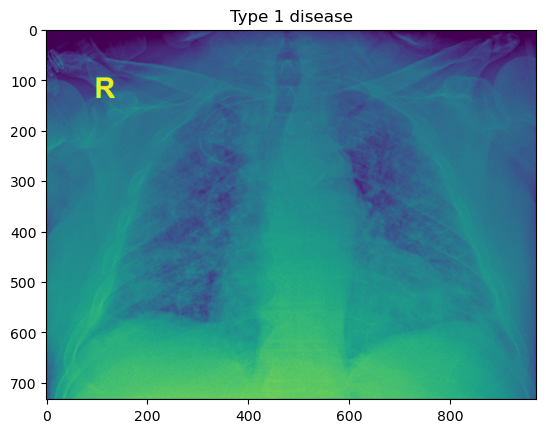

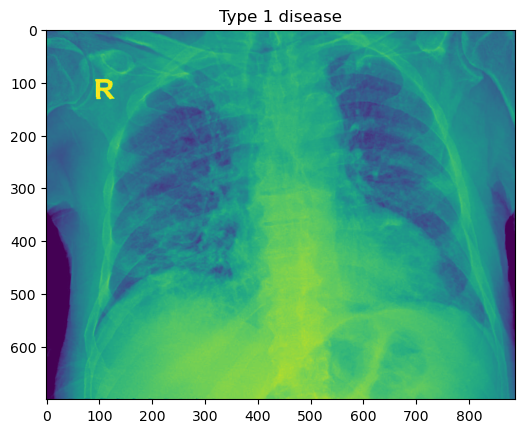

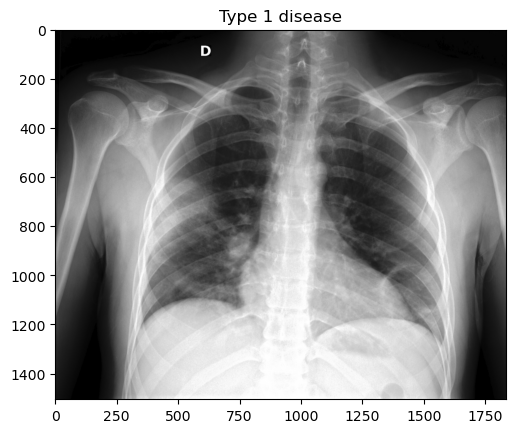

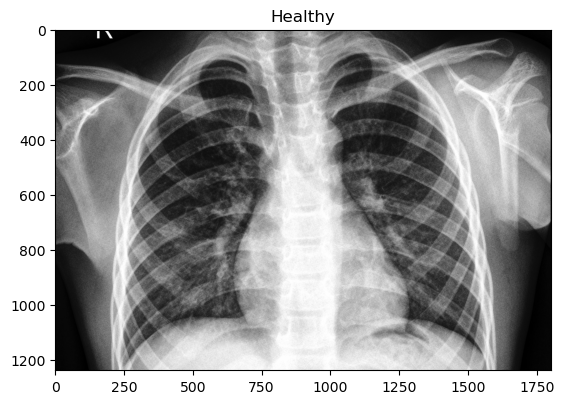

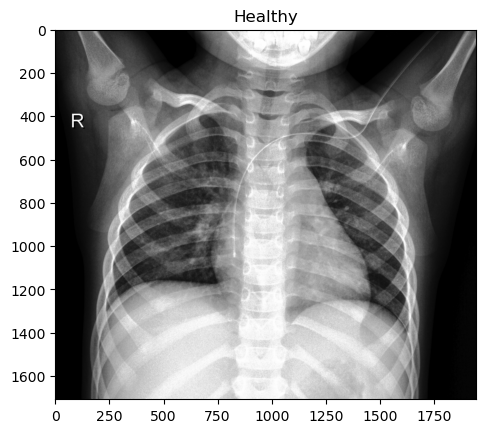

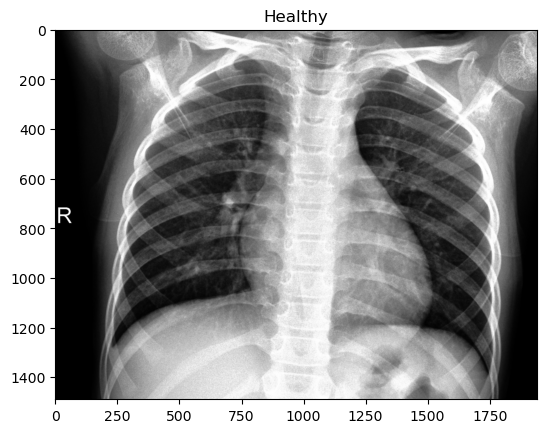

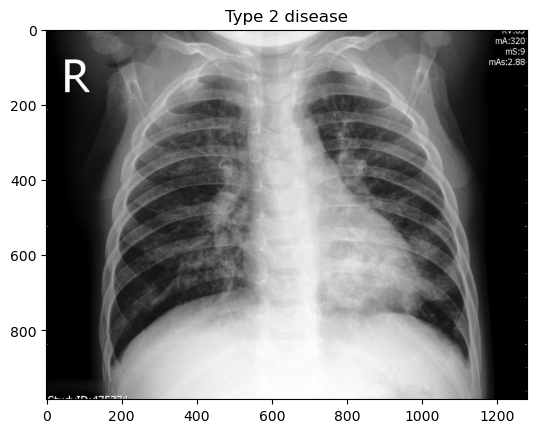

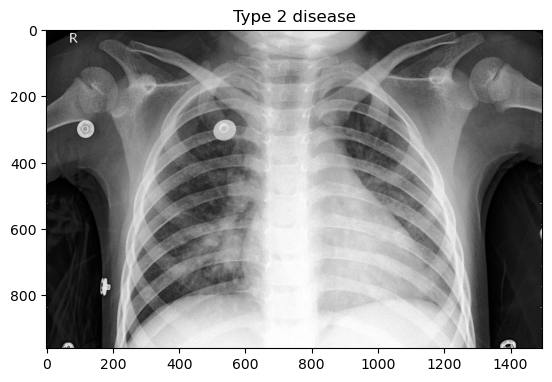

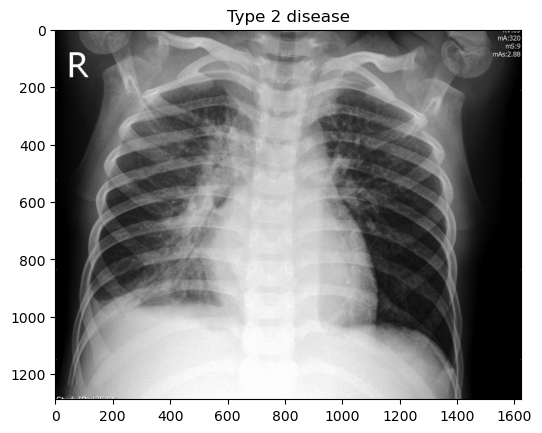

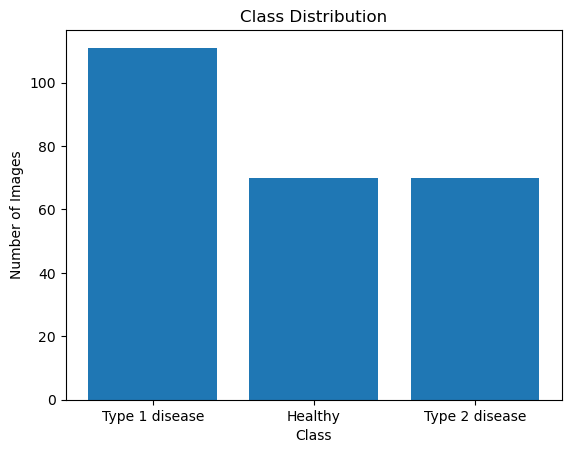

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

# Define the dataset paths
train_dir = '/Users/fahimafridi/Downloads/data/train'
test_dir = '/Users/fahimafridi/Downloads/data/test'

# Function to plot sample images
def plot_sample_images(folder_path, num_images=5):
    classes = os.listdir(folder_path)
    for cls in classes:
        class_path = os.path.join(folder_path, cls)
        images = os.listdir(class_path)
        sample_images = np.random.choice(images, num_images)
        for image in sample_images:
            img_path = os.path.join(class_path, image)
            img = plt.imread(img_path)
            plt.imshow(img)
            plt.title(cls)
            plt.show()

# Plot sample images for all classes in the training dataset
plot_sample_images(train_dir, num_images=3)

# Plot the distribution of images across the classes
def plot_class_distribution(folder_path):
    classes = os.listdir(folder_path)
    num_images_per_class = [len(os.listdir(os.path.join(folder_path, cls))) for cls in classes]
    plt.bar(classes, num_images_per_class)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution')
    plt.show()

plot_class_distribution(train_dir)

# Define data augmentation for train and test data
image_size = (48, 48)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
batch_size = 32
train_generator = train_datagen.flow_from_directory(train_dir, target_size=image_size, batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=image_size, batch_size=batch_size, class_mode='categorical')


Epoch 1/10
8/8 [==============================] - 6s 712ms/step - loss: 1.3689 - accuracy: 0.6215 - val_loss: 1.1639 - val_accuracy: 0.0455
Epoch 2/10
8/8 [==============================] - 5s 601ms/step - loss: 0.8723 - accuracy: 0.7291 - val_loss: 1.3296 - val_accuracy: 0.3030
Epoch 3/10
8/8 [==============================] - 5s 619ms/step - loss: 0.8648 - accuracy: 0.7331 - val_loss: 1.6702 - val_accuracy: 0.3030
Epoch 3: early stopping


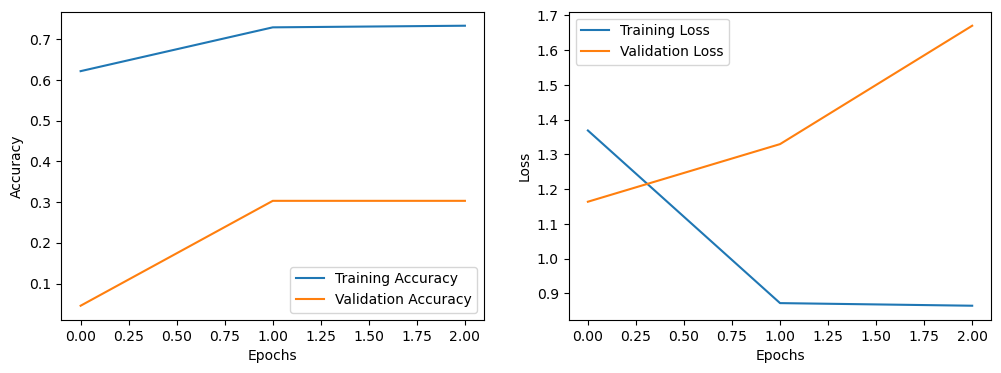

In [2]:
# Build the CNN model
model_cnn = Sequential()

# Convolutional Layer 1
model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.25))

# Convolutional Layer 2
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.25))

# Convolutional Layer 3
model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.25))

# Flatten the data for the fully connected layers
model_cnn.add(Flatten())

# Fully Connected Layers
model_cnn.add(Dense(512, activation='relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.5))

# Output Layer
model_cnn.add(Dense(3, activation='softmax'))

# Compile the model
model_cnn.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.001), metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)

# Train the model using a generator
epochs = 10
history = model_cnn.fit(train_generator, epochs=epochs, validation_data=test_generator, callbacks=[early_stopping])

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Epoch 1/10
8/8 [==============================] - 6s 704ms/step - loss: 1.1565 - accuracy: 0.5259 - val_loss: 1.0938 - val_accuracy: 0.3788
Epoch 2/10
8/8 [==============================] - 5s 661ms/step - loss: 1.0428 - accuracy: 0.6016 - val_loss: 1.1056 - val_accuracy: 0.2879
Epoch 3/10
8/8 [==============================] - 5s 637ms/step - loss: 1.0915 - accuracy: 0.5259 - val_loss: 1.1206 - val_accuracy: 0.3182
Epoch 3: early stopping


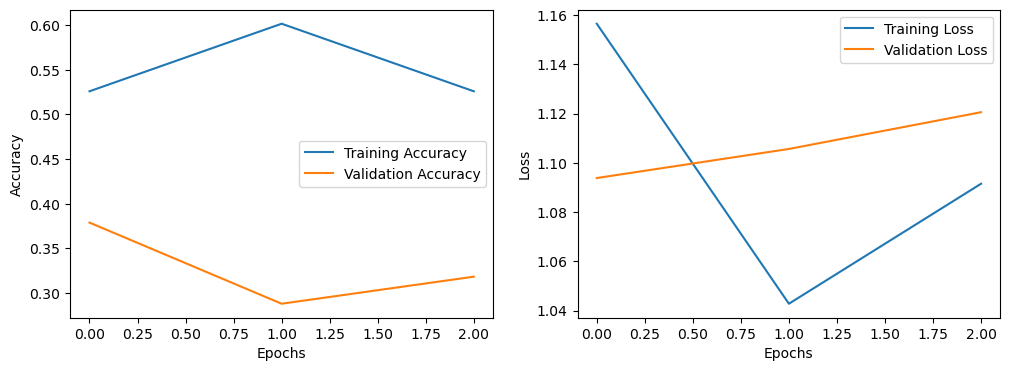

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
# Load the pre-trained MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add additional layers to the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)  # Change 3 to the number of classes

model_mobilenet = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the pre-trained MobileNet
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model_mobilenet.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.001), metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)

# Train the model using a generator
epochs = 10
history = model_mobilenet.fit(train_generator, epochs=epochs, validation_data=test_generator, callbacks=[early_stopping])

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


Epoch 1/15
36/36 [==============================] - 8s 168ms/step - loss: 1.3840 - accuracy: 0.5936 - val_loss: 3.0023 - val_accuracy: 0.1515
Epoch 2/15
36/36 [==============================] - 5s 150ms/step - loss: 0.9084 - accuracy: 0.6972 - val_loss: 3.6157 - val_accuracy: 0.2273
Epoch 3/15
36/36 [==============================] - 5s 152ms/step - loss: 0.9338 - accuracy: 0.7052 - val_loss: 3.9251 - val_accuracy: 0.2273
Epoch 3: early stopping


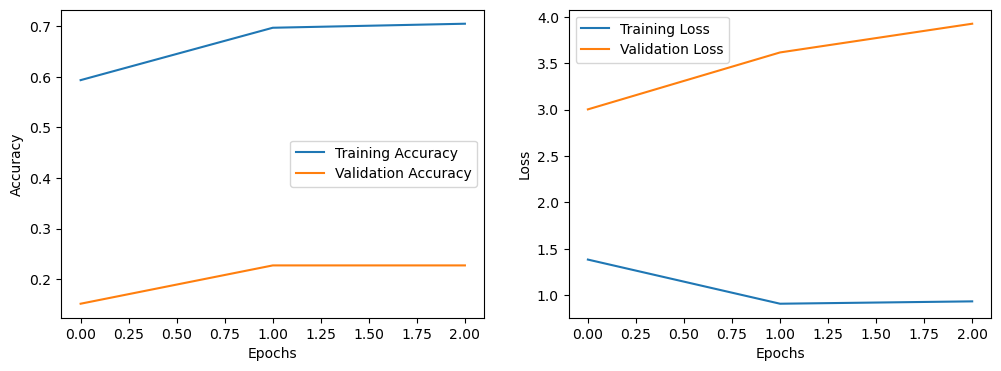

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

batch_size = 7
train_generator = train_datagen.flow_from_directory(train_dir, target_size=image_size, batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=image_size, batch_size=batch_size, class_mode='categorical')

# Load the pre-trained DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add additional layers to the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # You can try different dropout rates
predictions = Dense(3, activation='softmax')(x)  # Change 3 to the number of classes

model_densenet = Model(inputs=base_model.input, outputs=predictions)

# Freeze the top layers of the pre-trained DenseNet121
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model_densenet.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)

# Train the model using a generator
epochs = 15  # You can try different values
history = model_densenet.fit(train_generator, epochs=epochs, validation_data=test_generator, callbacks=[early_stopping])

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define a function to evaluate a model and return metrics
def evaluate_model(model, test_generator):
    predictions = model.predict(test_generator)
    y_true = test_generator.classes
    y_pred = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    return accuracy, precision, recall, f1

# Evaluate the three models
accuracy_cnn, precision_cnn, recall_cnn, f1_cnn = evaluate_model(model_cnn, test_generator)
accuracy_mobilenet, precision_mobilenet, recall_mobilenet, f1_mobilenet = evaluate_model(model_mobilenet, test_generator)
accuracy_densenet, precision_densenet, recall_densenet, f1_densenet = evaluate_model(model_densenet, test_generator)

# Print the metrics
print("CNN Model Metrics:")
print(f"Accuracy: {accuracy_cnn:.4f}")
print(f"Precision: {precision_cnn:.4f}")
print(f"Recall: {recall_cnn:.4f}")
print(f"F1-Score: {f1_cnn:.4f}")
print()

print("MobileNet Model Metrics:")
print(f"Accuracy: {accuracy_mobilenet:.4f}")
print(f"Precision: {precision_mobilenet:.4f}")
print(f"Recall: {recall_mobilenet:.4f}")
print(f"F1-Score: {f1_mobilenet:.4f}")
print()

print("DenseNet121 Model Metrics:")
print(f"Accuracy: {accuracy_densenet:.4f}")
print(f"Precision: {precision_densenet:.4f}")
print(f"Recall: {recall_densenet:.4f}")
print(f"F1-Score: {f1_densenet:.4f}")

10/10 [==============================] - 1s 62ms/step


/Users/fahimafridi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 1s 65ms/step
CNN Model Metrics:
Accuracy: 0.4848
Precision: 0.3378
Recall: 0.4848
F1-Score: 0.3979

MobileNet Model Metrics:
Accuracy: 0.2727
Precision: 0.2692
Recall: 0.2727
F1-Score: 0.2546

DenseNet121 Model Metrics:
Accuracy: 0.2879
Precision: 0.2832
Recall: 0.2879
F1-Score: 0.2852
